In [1]:
# Libraries used in this notebook
import pandas as pd
import numpy as np
import h5py
import os
import datetime
from matplotlib import pyplot as plt 
import seaborn as sns
import s3fs

In [2]:
# Converting factors
J_to_kWh = 1/3600000
area = 4982.22 # m2
kBtu_to_kWh = 0.293071
ft2_to_m2 = 0.092903
kBtu_per_ft2_to_kWh_per_m2 = kBtu_to_kWh/ft2_to_m2

In [3]:
# Utility functions
def get_df_from_hdf(hdf, climate='1A', efficiency='High', year='TMY3', str_run='run_1', data_key='ZonePeopleOccupantCount'):
    '''
    This function extracts the dataframe from the all run hdf5 file
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    sub = ts_root.get(climate).get(efficiency).get(year).get(str_run).get(data_key)
    cols = np.array(sub.get('axis0'))[1:].astype(str)
    data = np.array(sub.get('block1_values'))
    df = pd.DataFrame(data, columns = cols)
    df.index = [ts.strftime('%Y-%m-%d %H:%M:%S') for ts in pd.date_range('2006-01-01', '2007-01-01', freq='10min')[:-1]]
    return df

def ls_to_text_file(ls_lines, dir_txt_out, decode='UTF-8'):
    '''
    This function writes a list of strings to a text file
    '''
    with open(dir_txt_out, 'w') as filehandle:
        for line in ls_lines:
            filehandle.write(line.decode(decode))
        filehandle.close()

        
def get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, var='ElectricityFacility', convert=J_to_kWh):
    '''
    This function calculates the monthly sum of a specific variable from a yearly simulation
    '''
    df = get_df_from_hdf(
        hdf, 
        str_clm, 
        str_eff, 
        str_yr, 
        str_run, 
        var
    )
    df['datetime'] = pd.to_datetime(df.index)
    df = df.reset_index(drop=True)
    df['month'] = df['datetime'].dt.month
    df_temp = df.groupby('month').sum()*J_to_kWh
    return np.array(df_temp.iloc[:, 0])
        
        
def get_all_monthly_site_energy(hdf, str_clm, str_eff):
    '''
    This function getd the monthly site energy consumptions for all simulations in for a specific climate and efficiency level
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    dict_all_years = {}
    ls_yrs = list(ts_root.get(str_clm).get(str_eff).keys())
    for str_yr in ls_yrs:
        ls_runs = list(ts_root.get(str_clm).get(str_eff).get(str_yr).keys())  
        for i, str_run in enumerate(ls_runs):
            if i == 0:
                arr_monthly_sums = get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility') + get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
            else:
                arr_monthly_sums += get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility') + get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
        dict_all_years[str_yr] = (arr_monthly_sums/5)
    return dict_all_years


def get_all_weather(str_clm, hdf, start_year):
    '''
    This function gets the outdoor air temperature data for all years of the specific climate zone starting from a certain year.
    '''
    str_eff = 'Standard'
    str_run = 'run_1'
    count = 0
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    ls_yrs = list(ts_root.get(str_clm).get(str_eff).keys())
    for str_yr in ls_yrs:
        if str_yr != 'TMY3':
            dd = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'SiteOutdoorAirDrybulbTemperature')
            if count == 0:
                arr_all_t = dd.to_numpy()
            else:
                arr_all_t = np.concatenate((arr_all_t, dd.to_numpy()), axis=0)
        count += 1
    df_all_OAT = pd.DataFrame(arr_all_t, 
                              columns=['OAT'], 
                              index=pd.date_range(f'{start_year}-01-01', periods=1576800, freq='10Min'))
    df_all_OAT['datetime'] = df_all_OAT.index
    df_all_OAT['month'] = df_all_OAT['datetime'].dt.strftime('%Y-%m')
    return df_all_OAT


def get_ts_data(hdf, str_clm = '5A', str_eff = 'Standard', str_yr = '1992', str_run = 'run_1'):
    '''
    This function extracts the time series data from the HDF5 file
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    ts_root.get(str_clm).get(str_eff).get(str_yr).get(str_run).keys()
    df_oat = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'SiteOutdoorAirDrybulbTemperature')
    df_ele = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility')
    df_mels = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'InteriorEquipmentElectricity')
    df_lights = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'InteriorLightsElectricity')
    df_occs = pd.DataFrame(get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ZonePeopleOccupantCount').sum(axis=1), columns=['Total Occupant Count'])
    df_havc_ele = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityHVAC')
    df_gas = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
    
    df_col = pd.concat([df_occs, df_lights, df_mels, df_ele, df_gas, df_havc_ele, df_oat], axis=1)
    df_col['datetime'] = pd.to_datetime(df_col.index)
    df_col['climate'] = str_clm
    df_col['efficiency'] = str_eff
    df_col['weekday'] = np.where(df_col['datetime'].dt.dayofweek < 5, True, False)
    df_col['Interior Lighting (kWh)'] = df_col['InteriorLights:Electricity[J]'] * J_to_kWh
    df_col['MELs (kWh)'] = df_col['InteriorEquipment:Electricity[J]'] * J_to_kWh
    df_col['Site Electricity (kWh)'] = df_col['Electricity:Facility[J]'] * J_to_kWh
    df_col['Site Gas (kWh)'] = df_col['Gas:Facility[J]']* J_to_kWh
    df_col['Site Total Energy (kWh)'] = df_col['Site Electricity (kWh)'] + df_col['Site Gas (kWh)']
    df_col['HVAC Electricity (kWh)'] = df_col['Electricity:HVAC[J]'] * J_to_kWh
    df_col['Outdoor Air Temperature (degC)'] = df_col['Environment:Site Outdoor Air Drybulb Temperature[C]']
    df_col = df_col.drop(['InteriorLights:Electricity[J]', 
                          'InteriorEquipment:Electricity[J]', 
                          'Electricity:Facility[J]',
                          'Gas:Facility[J]',
                          'Environment:Site Outdoor Air Drybulb Temperature[C]'
                         ], axis=1)
    df_col['Operating Time'] = np.where(
        (df_col['datetime'].dt.hour > 6) & 
        (df_col['datetime'].dt.hour < 20) &
        (df_col['weekday'] == True), 'Yes', 'No')
    df_col['hour'] = df_col['datetime'].dt.hour
    return df_col

In [4]:
# Dataset structure
print('This HDF file contains a "1. README" file and a "2. Resources" folder, and a "3. Data" folder.')
print('The "2. Resources" folder contains "2.1. Building Models" and "2.2. Weather Files".')
print('The "3. Data" folder contains "3.1. Metadata" and "3.2. Timeseries".')

This HDF file contains a "1. README" file and a "2. Resources" folder, and a "3. Data" folder.
The "2. Resources" folder contains "2.1. Building Models" and "2.2. Weather Files".
The "3. Data" folder contains "3.1. Metadata" and "3.2. Timeseries".


In [5]:
# # Open a HDF file
# dir_to_HDF = '/Users/aoyuzou/Documents/ClassMaterial/CE290/Project'
# hdf = h5py.File(dir_to_HDF, 'r')

# Access the HDF5 file from AWS S3 bucket
dir_aws_s3 = 's3://oedi-data-lake/building_synthetic_dataset/A_Synthetic_Building_Operation_Dataset.h5'
s3 = s3fs.S3FileSystem()
hdf = h5py.File(s3.open(dir_aws_s3, "rb"))

In [6]:
# Read resources files from the HDF and write them to files

dir_to_file = '' # replace this to your desired output path
# Read seed models
print('- ' * 30)
print('The seed models are:')
for key_model in hdf.get('2. Resources').get('2.1. Building Models').keys():
    print(key_model)

# e.g., Write the model for climate zone 5A with high efficiency level.
lines = hdf.get('2. Resources').get('2.1. Building Models').get('MediumOfficeDetailed_90.1-2013_5A_High_efficiency.osm')
# ls_to_text_file(lines, os.path.join(dir_to_file, 'model.osm'))

print('- ' * 30)
print('The weather files are for ASHRAE climates:')
for key_model in hdf.get('2. Resources').get('2.2. Weather Files').keys():
    print(key_model)

# e.g., Write a single year's weather file of climate 1A to epw file
lines = hdf.get('2. Resources').get('2.2. Weather Files').get('1A').get('Miami_2005.epw')
# ls_to_text_file(lines, os.path.join(dir_to_file, 'weather.epw'))


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
The seed models are:
MediumOfficeDetailed_90.1-2013_1A_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_1A_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_1A_Standard_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_Standard_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_Standard_efficiency.osm
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
The weather files are for ASHRAE climates:
1A
3C
5A


In [7]:
# Read the metadata, and write them to a local TTL file for inspection

lines = hdf.get('3. Data').get('3.1. Metadata').get('brick_relationhsips.ttl')
dir_to_file = '' # replace this to your desired output path
ls_to_text_file(lines, os.path.join(dir_to_file, 'brick_relationhsips.ttl'))

In [8]:
# Read the time-series data into a Pandas dataframe

# list all the variables of a single simulation
ls_variables = list(hdf.get('3. Data').get('3.2. Timeseries').get('1A').get('Standard').get('TMY3').get('run_1').keys())

# get the variables in Pandas dataframe for a specific run
str_climate = '1A'
str_efficiency = 'Standard'
str_year = '2000'
str_run = 'run_1'
str_var = 'ElectricityFacility'

df_example_1 = get_df_from_hdf(
    hdf=hdf, 
    climate=str_climate, 
    efficiency=str_efficiency, 
    year=str_year, 
    str_run=str_run, 
    data_key=str_var
)

df_example_1.describe()

,Electricity:Facility[J]
count,5.256000e+04
mean,4.531469e+07
std,2.905393e+07
min,5.799975e+06
25%,1.844440e+07
50%,3.514069e+07
75%,7.354144e+07
max,1.159792e+08


Outdoor Air Temperature

In [9]:
# # Get all weather data
# df_all_OAT_3C = get_all_weather('3C', hdf, 1988)

In [10]:
# import matplotlib.dates as mdates

# hist_range = (0, 300) # For total eui
# # hist_range = (0, 15) # For natural gas eui


# fig, ax = plt.subplots(figsize=(40, 15))

# # Plot the weather data
# arr_raw_3C = df_all_OAT_3C['OAT']
# arr_annuaul_moving_avg_3C = df_all_OAT_3C['OAT'].rolling(window=52560, center=True, min_periods=360).mean()
# arr_30d_moving_avg_3C = df_all_OAT_3C['OAT'].rolling(window=4320, center=True, min_periods=360).mean()


# ax.xaxis.set_major_locator(mdates.YearLocator() )
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.tick_params(axis='both', which='major', labelsize=16)


# # axes[1].set_ylim(-5, 40)
# ax.set_xlim(arr_raw_3C.index[0], arr_raw_3C.index[-1])
# ax.plot(arr_raw_3C, color='0.6', alpha=0.7, linestyle="", marker='o', markersize=0.5)
# ax.plot(arr_annuaul_moving_avg_3C, alpha=0.8)
# ax.plot(arr_30d_moving_avg_3C, alpha=0.7)
# ax.set_title(f"San Francisco", size=17)


# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=1, borderaxespad=2, prop={'size': 16})
# fig.subplots_adjust(hspace=0.23, top=0.92)
# fig.suptitle('Historical Outdoor Air Temperature (degC)', size=20)
# # fig.savefig('historical weather.png', dpi=600)

In [11]:
# df_all_OAT_3C

Site energy vs other variables scatter plot


In [12]:
# Get all time-series data
df_ts = get_ts_data(hdf, str_clm = '3C', str_eff = 'Standard', str_yr = 'TMY3', str_run = 'run_1')

AttributeError: 'PathCollection' object has no property 'x_jitter'

<Figure size 640x480 with 0 Axes>

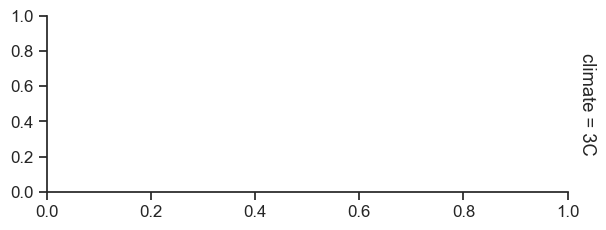

In [13]:
# Plot the occupant count vs site energy use intensity scatters

sns.set(font_scale=1.1)
sns.set_style("ticks")
sns.set_palette("tab10")
sns.despine()
g = sns.FacetGrid(df_ts, row="climate", hue="efficiency", 
                  margin_titles=True, height=2.5, aspect=2.5,
                  sharex=True, sharey=True)
# g.map(sns.scatterplot, "Total Occupant Count", "Interior Lighting (kWh)", x_jitter=.1, s=12, alpha=0.2)
g.map(sns.scatterplot, "Total Occupant Count", "Site Total Energy (kWh)", x_jitter=.1, s=12, alpha=0.2)

g.set_axis_labels("Occupant Count", "kWh")
plt.subplots_adjust(top=0.91)
g.fig.suptitle('Total Occupant Count and Site Energy Consumption (10-minute interval)') # can also get the figure from plt.gcf()
g.add_legend()

In [14]:
# df_ts['Total Occupant Count'][df_ts['Total Occupant Count'] < 20] = 0
# df_ts['Total Occupant Count'][(df_ts['Total Occupant Count'] > 20) & (df_ts['Total Occupant Count'] < 50)] = 1
# df_ts['Total Occupant Count'][(df_ts['Total Occupant Count'] > 50) & (df_ts['Total Occupant Count'] < 100)] = 2
# df_ts['Total Occupant Count'][(df_ts['Total Occupant Count'] > 100) & (df_ts['Total Occupant Count'] < 200)] = 3


In [15]:
# sns.set(font_scale=1.1)
# sns.set_style("ticks")
# sns.set_palette("tab10")
# sns.despine()
# g = sns.FacetGrid(df_ts, row="hour", hue="Total Occupant Count", 
#                   margin_titles=True, height=2.5, aspect=2.5,
#                   sharex=True, sharey=True)

# g.map(sns.scatterplot, "Outdoor Air Temperature (degC)", "Site Total Energy (kWh)", x_jitter=.1, s=12, alpha=0.2)

# g.set_axis_labels("degC", "kWh")
# plt.subplots_adjust(top=0.91)
# g.fig.suptitle('Outdoor Air Temperature and Site Energy Consumption (10-minute interval)') # can also get the figure from plt.gcf()
# g.add_legend()

In [16]:
df_ts

,Total Occupant Count,Electricity:HVAC[J],datetime,climate,efficiency,weekday,Interior Lighting (kWh),MELs (kWh),Site Electricity (kWh),Site Gas (kWh),Site Total Energy (kWh),HVAC Electricity (kWh),Outdoor Air Temperature (degC),Operating Time,hour
2006-01-01 00:00:00,0.0,0.000000e+00,2006-01-01 00:00:00,3C,Standard,False,0.821181,2.772776,4.466209,0.212824,4.679034,0.000000,6.783333,No,0
2006-01-01 00:10:00,0.0,6.838239e+05,2006-01-01 00:10:00,3C,Standard,False,0.821181,2.772776,4.656160,0.212824,4.868985,0.189951,6.866667,No,0
2006-01-01 00:20:00,0.0,2.676857e+06,2006-01-01 00:20:00,3C,Standard,False,0.821181,2.772776,5.209780,0.212824,5.422605,0.743571,6.950000,No,0
2006-01-01 00:30:00,0.0,2.666149e+06,2006-01-01 00:30:00,3C,Standard,False,0.821181,2.772776,5.206806,0.212824,5.419631,0.740597,7.033333,No,0
2006-01-01 00:40:00,0.0,0.000000e+00,2006-01-01 00:40:00,3C,Standard,False,0.821181,2.772776,4.466209,0.212824,4.679034,0.000000,7.116667,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 23:10:00,0.0,3.161439e+06,2006-12-31 23:10:00,3C,Standard,False,0.821181,2.772776,5.822047,0.212824,6.034872,0.878177,10.766667,No,23
2006-12-31 23:20:00,0.0,3.116913e+06,2006-12-31 23:20:00,3C,Standard,False,0.821181,2.772776,5.809679,0.212824,6.022504,0.865809,10.850000,No,23
2006-12-31 23:30:00,0.0,3.116203e+06,2006-12-31 23:30:00,3C,Standard,False,0.821181,2.772776,5.809482,0.212824,6.022306,0.865612,10.933333,No,23
2006-12-31 23:40:00,0.0,0.000000e+00,2006-12-31 23:40:00,3C,Standard,False,0.821181,2.772776,4.943870,0.212824,5.156694,0.000000,11.016667,No,23


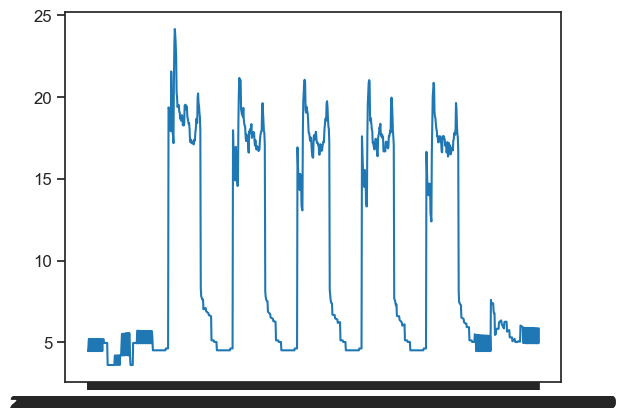

In [17]:
plt.plot(df_ts['Site Electricity (kWh)'][0:6*24*7])

# Neural network

### Single step prediction in LST Memory RNN

In [18]:
"""
Single-step ahead forecasting
Forecasting 1 step ahead using a LSTM network
"""

#Imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [19]:
#scale the timeseries using standard scaler
ts = np.asarray(df_ts['Site Electricity (kWh)']).reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(ts)
ts_scaled = list(scaler.transform(ts))

In [20]:
#Methods
def make_X_Y(ts:list, lag:int):
    """
    Create X and Y matrices needed for NN training
    """
    X,Y = [], []

    for i in range(len(ts) - lag):
        Y.append(ts[i + lag])
        X.append(ts[i:i+lag])

    X,Y = np.array(X), np.array(Y)

    #reshape array into standard form for timeseries
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X,Y

def make_train_test_data(ts:list, lag:int, train_test_split:float):
    """
    Create training and testing data for NN
    """
    #create X and Y matrices
    X,Y = make_X_Y(ts, lag)

    #split into test and train
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []

    if train_test_split > 0:
        idx = round(len(X) * train_test_split)
        X_train = X[:(len(X) - idx)]
        X_test = X[-idx:]

        Y_train = Y[:(len(Y) - idx)]
        Y_test = Y[-idx:]

    return X_train, X_test, Y_train, Y_test

In [21]:
#Deep Learning

#number of neurons in LSTM layer
n_layer = 50

#number of lags
n_lag = 3

#Model
model = keras.Sequential(
    [
    layers.LSTM(n_layer, activation='relu', input_shape=(n_lag,1)),
    layers.Dense(1)
    ]
)
#compile model
model.compile(optimizer='adam', loss='mse')

epochs = 10
batch_size = 256
train_test_split = 0.15

#create train and testing data
X_train, X_test, Y_train, Y_test = make_train_test_data(ts_scaled, n_lag, train_test_split)

#create a dict for keras training args
keras_dict = {
    'x':X_train,
    'y':Y_train,
    'batch_size':batch_size,
    'epochs':epochs,
    'shuffle':False,
    'validation_data':(X_test,Y_test)
}

2023-01-18 15:49:55.238594: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:49:55.239653: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [22]:
X_train[0]

array([[-0.91269653],
       [-0.88013936],
       [-0.78525015]])

In [23]:
X_train[1]

array([[-0.88013936],
       [-0.78525015],
       [-0.78575996]])

In [24]:
X_train[2]

array([[-0.78525015],
       [-0.78575996],
       [-0.91269653]])

In [25]:
Y_train[0]

array([-0.78575996])

In [26]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (44673, 3, 1)
Y_train shape: (44673, 1)


In [27]:
#fit the model
model.fit(**keras_dict)

Train on 44673 samples, validate on 7884 samples
Epoch 1/10
44673/44673 [==============================] - 4s 97us/sample - loss: 0.2260 - val_loss: 0.0467
Epoch 2/10
44673/44673 [==============================] - 3s 59us/sample - loss: 0.0443 - val_loss: 0.0402
Epoch 3/10
44673/44673 [==============================] - 3s 62us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/10
44673/44673 [==============================] - 3s 58us/sample - loss: 0.0348 - val_loss: 0.0334
Epoch 5/10
44673/44673 [==============================] - 3s 57us/sample - loss: 0.0334 - val_loss: 0.0331
Epoch 6/10
44673/44673 [==============================] - 3s 59us/sample - loss: 0.0326 - val_loss: 0.0329
Epoch 7/10
44673/44673 [==============================] - 3s 58us/sample - loss: 0.0322 - val_loss: 0.0329
Epoch 8/10
44673/44673 [==============================] - 3s 58us/sample - loss: 0.0318 - val_loss: 0.0328
Epoch 9/10
44673/44673 [==============================] - 3s 59us/sample - loss: 0.0314 - val_l

In [ ]:
#predict
yhat = []
yhat = [y[0] for y in model.predict(X_test)]

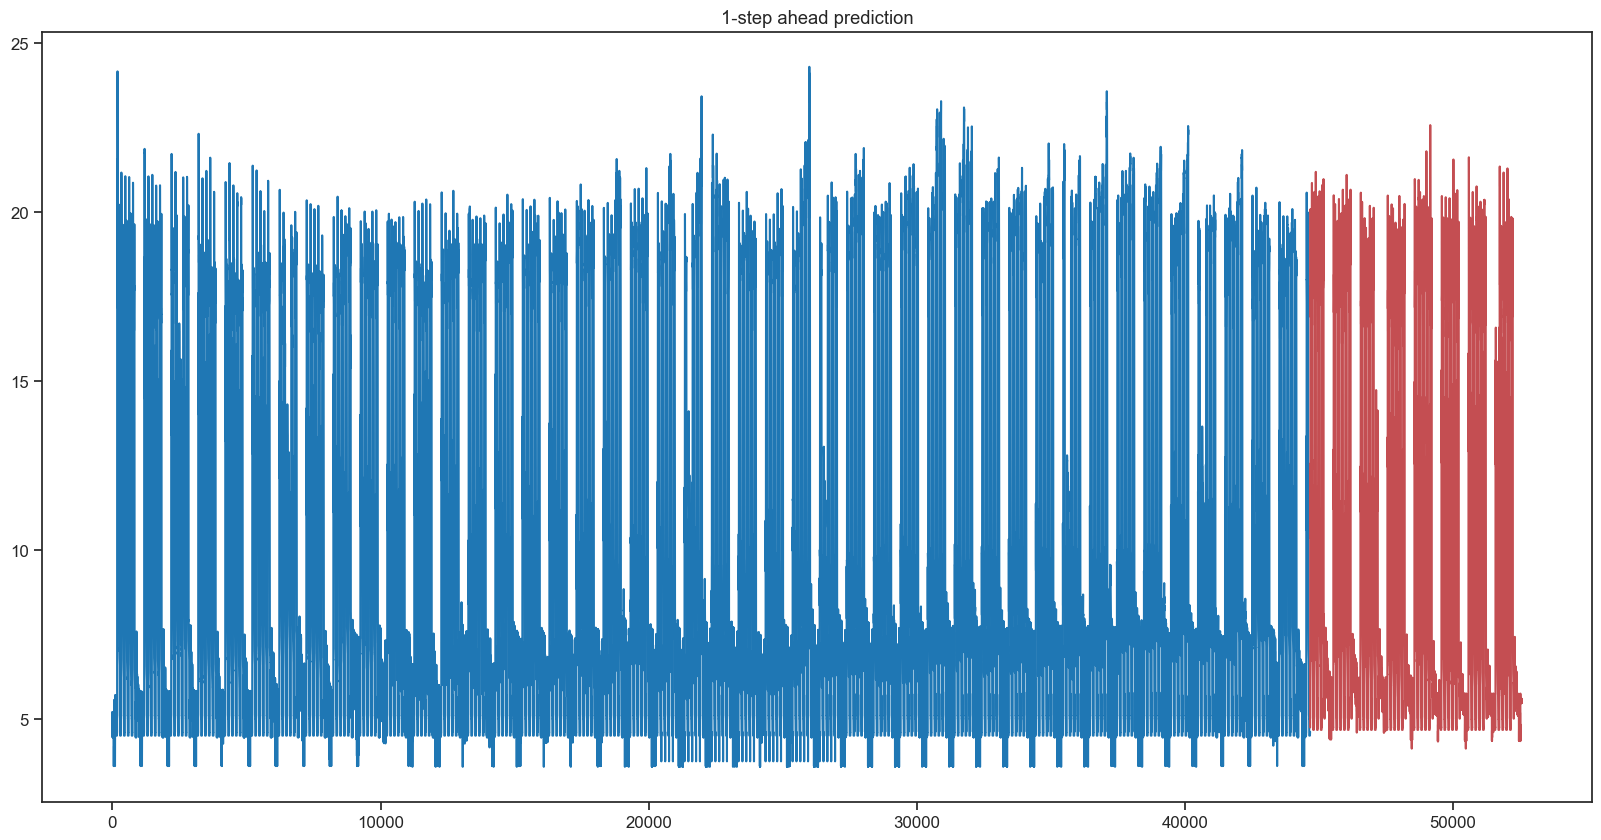

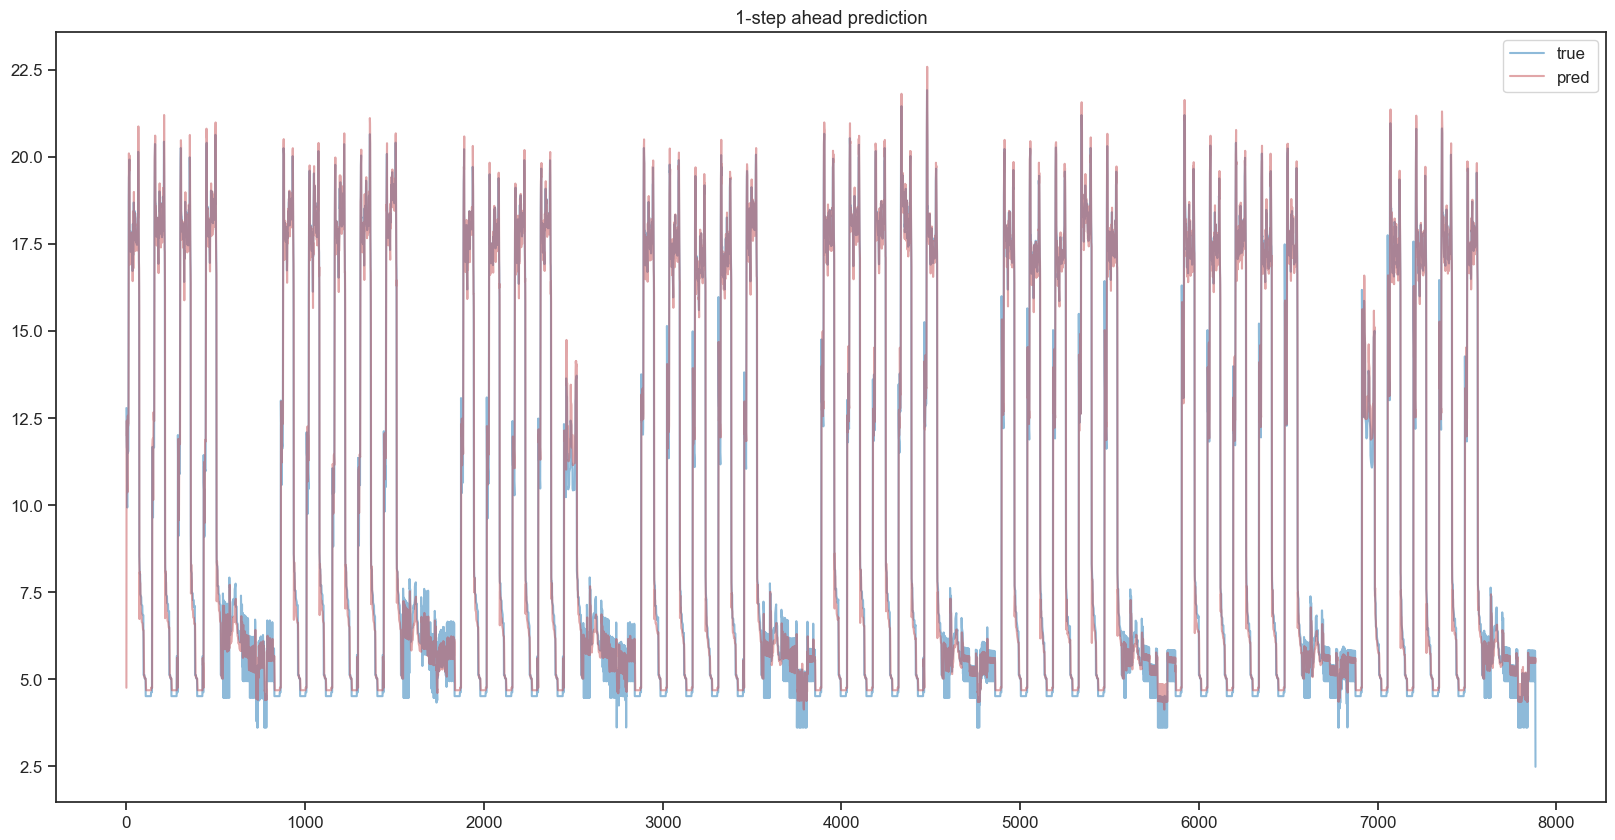

In [ ]:
#Inverse transform scaled data
Y_train_inv = scaler.inverse_transform(np.asarray(Y_train))
Y_test_inv = scaler.inverse_transform(Y_test)
yhat_inv = list( (scaler.inverse_transform(np.asarray(yhat).reshape(-1,1))).squeeze() )

#Compare training data and 1 step ahead prediction
idx_train = len(Y_train)
idx_test = len(Y_test)
train_range = range(0, idx_train)
test_range = range(idx_train, idx_train + idx_test)
plt.figure(figsize=[20, 10])
plt.plot(range(0,len(Y_train)),Y_train_inv)
plt.plot(test_range,yhat_inv,'r')
plt.title('1-step ahead prediction')
# plt.xlabel('hour')
# plt.ylabel('MW')
plt.show()

plt.figure(figsize=[20, 10])
plt.plot(Y_test_inv,label='true', alpha=0.5)
plt.plot(yhat_inv,'r',label='pred', alpha=0.5)
plt.title('1-step ahead prediction')
# plt.xlabel('hour')
# plt.ylabel('MW')
plt.legend()
plt.show()

### Multi-step prediction in LST Memory RNN

In [ ]:
#create 3D array of timeseries of fixed length
# Guess: n_ahead -> how many times step should be preditced based on 1 time step input
#        n_lag -> how many training should be given to do the prediction (how many times of training)

# four hours prediction (10 minutes resolution in data)
# Multistep LSTM prediction is basically doing 1 step prediction for iterative way -> could accumulate prediction error
n_ahead = 6*4
n_lag = 120

max_idx = int(np.floor(len(ts_scaled) / (n_lag + n_ahead)))


series = []
for i in range(0, max_idx):
    n = n_lag + n_ahead
    series.append(ts_scaled[i*n : (i+1) * n])

#create training matrix and target vector
# For every second-dimension elements inside first-dimension package, select 0:n_lag elements with all thrid dimension elements
# Generally, the dimension should be similar, and the first element in x -> n_ahead elements in y
X = np.asarray(series)[:,0:n_lag,:]
y = np.empty((np.shape(X)[0], np.shape(X)[1], n_ahead))

# Y is extracted rolling over the time series at the interval of i:i+n_lag
# The extracted is n_lag elements from (n_lag + n_ahead) series, which has n_ahead sets
# Although Y has the same interval length (i:i+n_lag), Y always strats one step ahead of corresponding x
for i in range(1, n_ahead+1):
    y[:,:,i-1] = np.asarray(series)[:,i:i+n_lag,0]


In [ ]:
print('Dimension of series:', np.asarray(series).shape)
print('Length of elements in 1 series assmebly:', len(np.asarray(series)[0]))
print('Dimension of X:', X.shape)
print('Dimension of y:', y.shape)

Dimension of series: (365, 144, 1)
Length of elements in 1 series assmebly: 144
Dimension of X: (365, 120, 1)
Dimension of y: (365, 120, 24)


In [ ]:
# Weekly prediction
# weekl 1
week1_y = np.asarray(series)[:7].reshape(-1, 1)

# extract the first time seris at the first ten minutes for 4 hours
week1_x = []
for i in range(len(week1_y)):
    if i%(6*4) == 1:
        week1_x.append(week1_y[i])
week1_x = np.asarray([week1_x])

# week 2
week2_y = np.asarray(series)[7:14].reshape(-1, 1)

# extract the first time seris at the first ten minutes for 4 hours
week2_x = []
for i in range(len(week2_y)):
    if i%(6*4) == 1:
        week2_x.append(week2_y[i])
week2_x = np.asarray([week2_x])

# week 3
week3_y = np.asarray(series)[14:21].reshape(-1, 1)

# extract the first time seris at the first ten minutes for 4 hours
week3_x = []
for i in range(len(week3_y)):
    if i%(6*4) == 1:
        week3_x.append(week3_y[i])
week3_x = np.asarray([week3_x])

# week 4
week4_y = np.asarray(series)[21:28].reshape(-1, 1)

# extract the first time seris at the first ten minutes for 4 hours
week4_x = []
for i in range(len(week4_y)):
    if i%(6*4) == 1:
        week4_x.append(week4_y[i])
week4_x = np.asarray([week4_x])

In [ ]:
#create training, validation, and testing sets
train_valid_test = [0.7,0.2,0.1]
train_valid_test_idx = np.floor(np.asarray(train_valid_test) * max_idx).astype(int)
X_train, y_train = X[0:train_valid_test_idx[0],:,:], y[0:train_valid_test_idx[0],:,:]
X_valid, y_valid = X[0:train_valid_test_idx[1],:,:], y[0:train_valid_test_idx[1],:,:]
X_test, y_test = X[0:train_valid_test_idx[2],:,:], y[0:train_valid_test_idx[2],:,:]

In [ ]:
print('Dimension of X_test', X_test.shape)
print('Dimension of Y_test', y_test.shape)

Dimension of X_test (36, 120, 1)
Dimension of Y_test (36, 120, 24)


In [ ]:
#LSTM
num_neurons = 50
model = keras.models.Sequential([
    keras.layers.LSTM(num_neurons, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(num_neurons, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
    ])

#custom loss function
def last_timestep_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])

#compile model
lr = 0.01
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='mse', metrics=[last_timestep_mse])

epochs = 100

#create a dict for keras training args
keras_dict = {
    'x':X_train,
    'y':y_train,
    'epochs':epochs,
    'shuffle':False,
    'validation_data':(X_valid,y_valid)
}

#fit the model
model.fit(**keras_dict)

Train on 255 samples, validate on 73 samples
Epoch 1/100


2023-01-17 23:24:53.682529: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_11621_12106' and '__inference___backward_standard_lstm_11621_12106_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_12762' both implement 'lstm_a6bb2e4d-cc61-4220-a995-2e896fc1ff48' but their signatures do not match.


224/255 [=========================>....] - ETA: 1s - loss: 0.7428 - last_timestep_mse: 0.4219

2023-01-17 23:25:00.085569: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_12979' and '__inference_standard_lstm_12979_specialized_for_sequential_1_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_13804' both implement 'lstm_9d3a2ff8-6d3a-4ebc-a0b3-0951f24e7731' but their signatures do not match.


255/255 [==============================] - 9s 36ms/sample - loss: 0.7156 - last_timestep_mse: 0.4277 - val_loss: 0.5180 - val_last_timestep_mse: 0.1637
Epoch 2/100
255/255 [==============================] - 4s 17ms/sample - loss: 0.3948 - last_timestep_mse: 0.1901 - val_loss: 0.4280 - val_last_timestep_mse: 0.0365
Epoch 3/100
255/255 [==============================] - 4s 17ms/sample - loss: 0.3602 - last_timestep_mse: 0.1984 - val_loss: 0.3432 - val_last_timestep_mse: 0.0187
Epoch 4/100
255/255 [==============================] - 4s 17ms/sample - loss: 0.4321 - last_timestep_mse: 0.2434 - val_loss: 0.4340 - val_last_timestep_mse: 0.1636
Epoch 5/100
255/255 [==============================] - 4s 17ms/sample - loss: 0.4007 - last_timestep_mse: 0.1098 - val_loss: 0.3940 - val_last_timestep_mse: 0.0205
Epoch 6/100
255/255 [==============================] - 4s 17ms/sample - loss: 0.3448 - last_timestep_mse: 0.2063 - val_loss: 0.4563 - val_last_timestep_mse: 0.2623
Epoch 7/100
255/255 [=======

2023-01-17 23:31:57.873973: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_18590' and '__inference_standard_lstm_18479_specialized_for_sequential_1_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_18785' both implement 'lstm_712b9b33-08f1-43d6-98a0-46d26339fd08' but their signatures do not match.


Text(0, 0.5, 'Electricity Consumption')

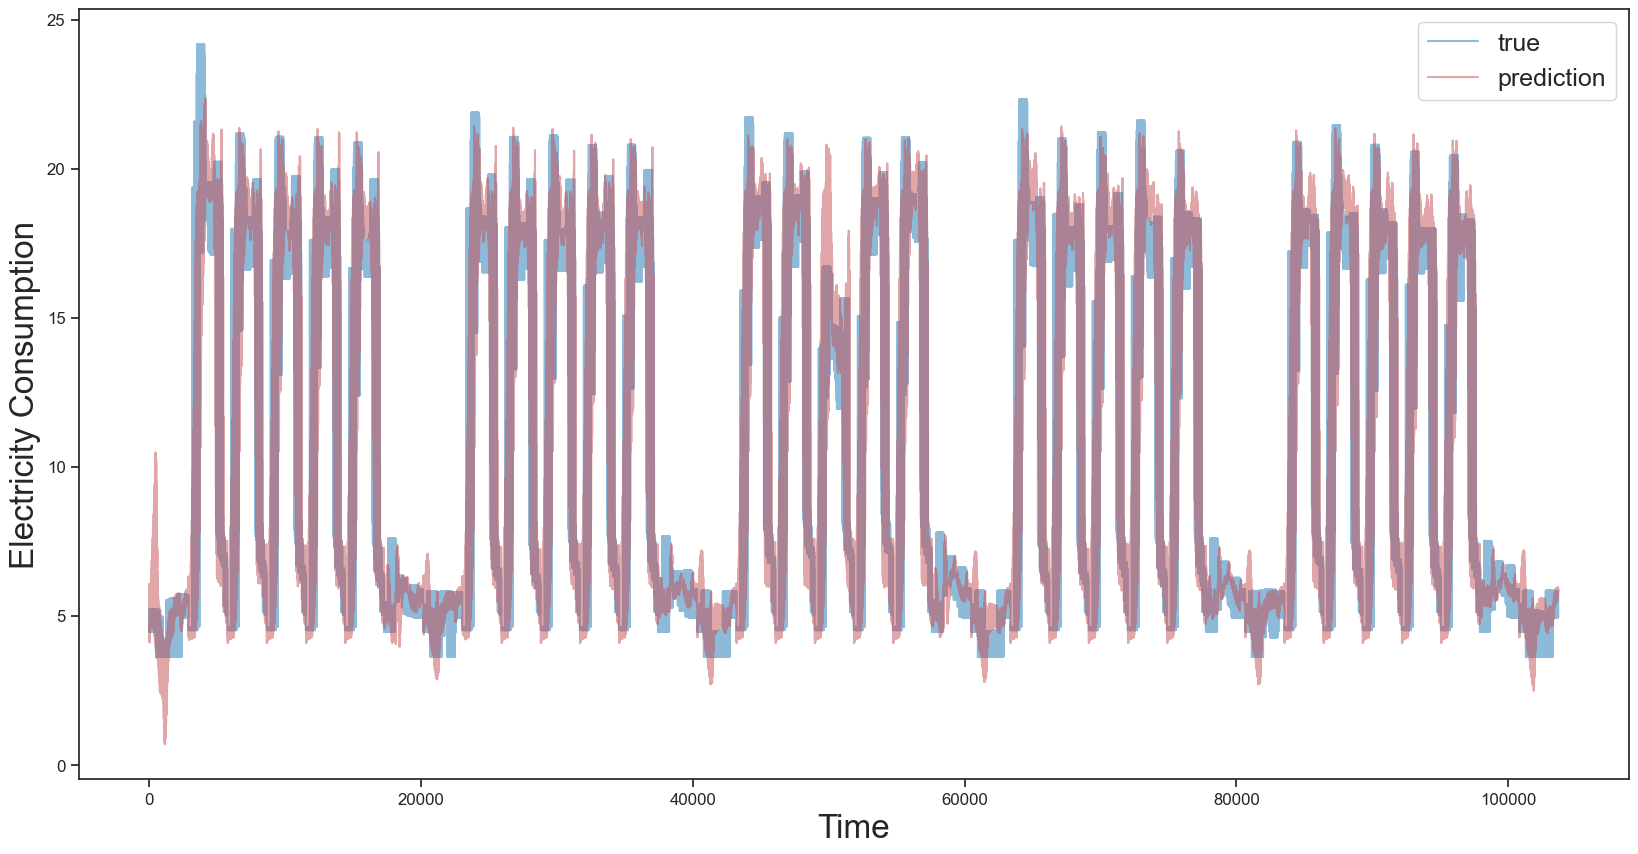

In [ ]:
#predict
y_pred = model.predict(X_test)

#Inverse transform scaled data
y_true = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))

plt.figure(figsize=[20, 10])
plt.plot(y_true,label='true', alpha=0.5)
plt.plot(y_pred,'r',label='prediction', alpha=0.5)
plt.legend(fontsize=18)
plt.xlabel("Time", fontsize=24)
plt.ylabel('Electricity Consumption', fontsize=24)


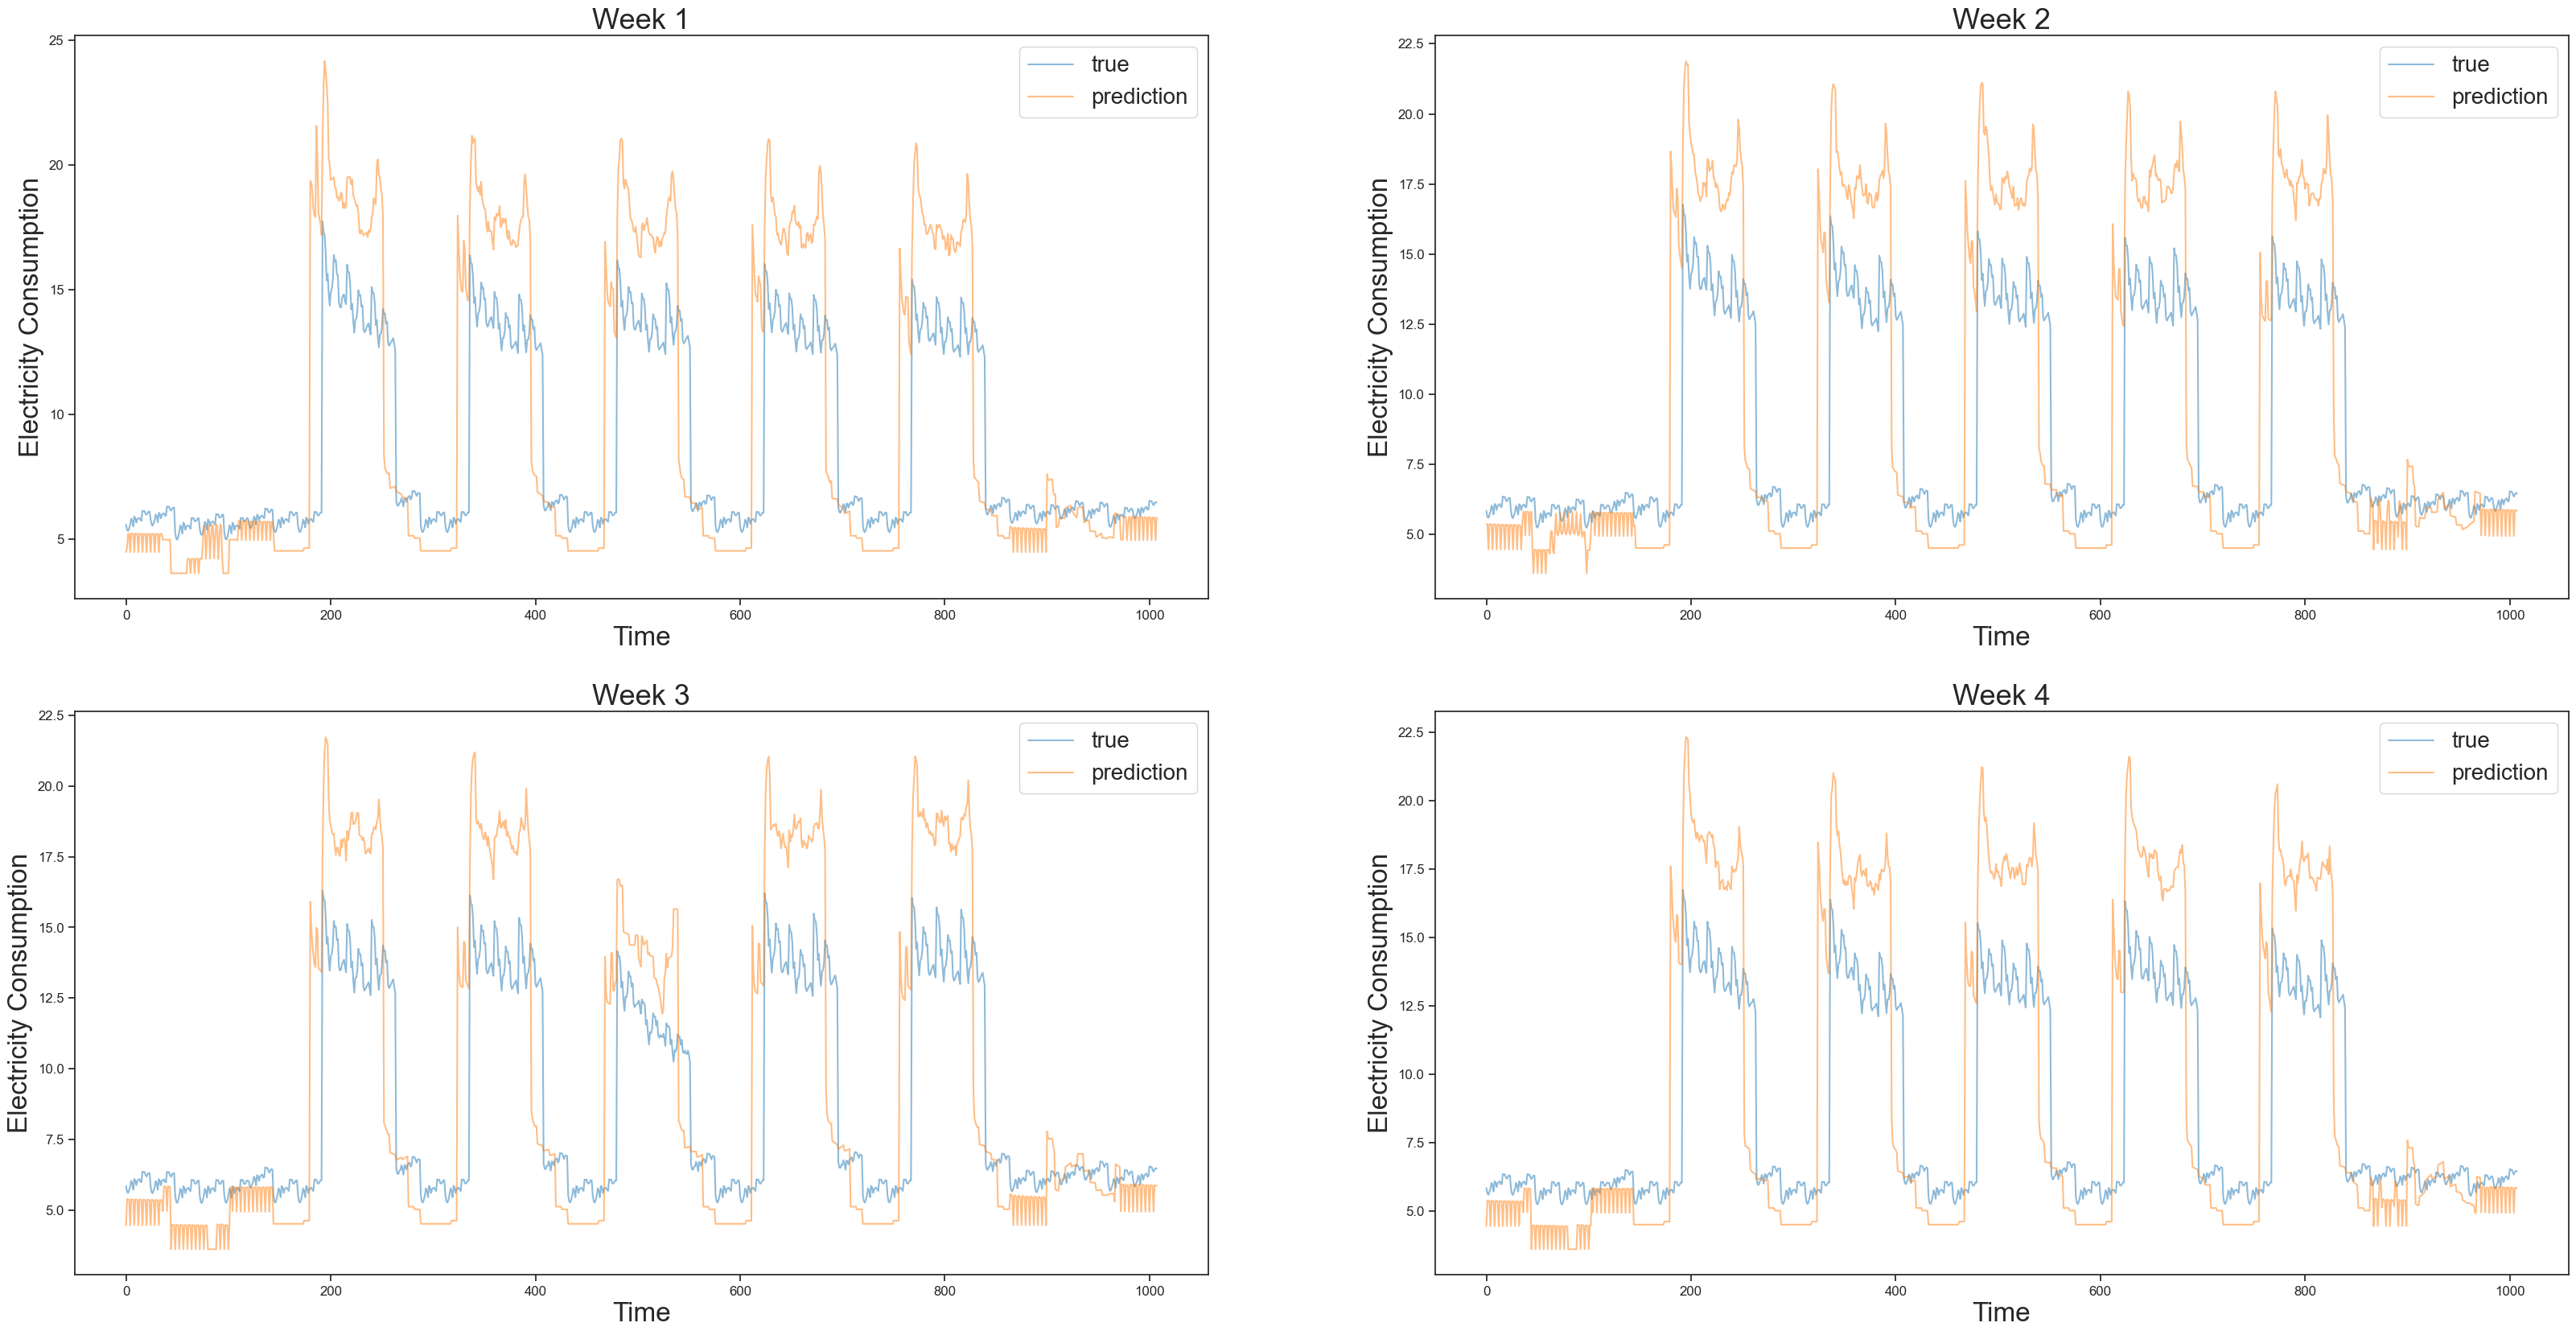

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[40, 20])

week1_result = []
for i in range(42):
    week1_result.append(model.predict(week1_x[0:1, i:i+1, 0:1]))

axs[0, 0].plot(scaler.inverse_transform(np.asarray(week1_result).reshape(-1,1)),label='true', alpha=0.5)
axs[0, 0].plot(scaler.inverse_transform(week1_y.reshape(-1,1)),label='prediction', alpha=0.5)
axs[0, 0].set_title('Week 1', fontsize=26)
axs[0, 0].set_xlabel('Time', fontsize=24)
axs[0, 0].set_ylabel('Electricity Consumption', fontsize=24)
axs[0, 0].legend(fontsize=20)

week2_result = []
for i in range(42):
    week2_result.append(model.predict(week2_x[0:1, i:i+1, 0:1]))

axs[0, 1].plot(scaler.inverse_transform(np.asarray(week2_result).reshape(-1,1)),label='true', alpha=0.5)
axs[0, 1].plot(scaler.inverse_transform(week2_y.reshape(-1,1)),label='prediction', alpha=0.5)
axs[0, 1].set_title('Week 2', fontsize=26)
axs[0, 1].set_xlabel('Time', fontsize=24)
axs[0, 1].set_ylabel('Electricity Consumption', fontsize=24)
axs[0, 1].legend(fontsize=20)

week3_result = []
for i in range(42):
    week3_result.append(model.predict(week3_x[0:1, i:i+1, 0:1]))

axs[1, 0].plot(scaler.inverse_transform(np.asarray(week3_result).reshape(-1,1)),label='true', alpha=0.5)
axs[1, 0].plot(scaler.inverse_transform(week3_y.reshape(-1,1)),label='prediction', alpha=0.5)
axs[1, 0].set_title('Week 3', fontsize=26)
axs[1, 0].set_xlabel('Time', fontsize=24)
axs[1, 0].set_ylabel('Electricity Consumption', fontsize=24)
axs[1, 0].legend(fontsize=20)

week4_result = []
for i in range(42):
    week4_result.append(model.predict(week4_x[0:1, i:i+1, 0:1]))

axs[1, 1].plot(scaler.inverse_transform(np.asarray(week4_result).reshape(-1,1)),label='true', alpha=0.5)
axs[1, 1].plot(scaler.inverse_transform(week4_y.reshape(-1,1)),label='prediction', alpha=0.5)
axs[1, 1].set_title('Week 4', fontsize=26)
axs[1, 1].set_xlabel('Time', fontsize=24)
axs[1, 1].set_ylabel('Electricity Consumption', fontsize=24)
axs[1, 1].legend(fontsize=20)